# Úvod

FordA dataset je jednou z populárních časových řad využívaných v oblasti strojového učení, konkrétně v klasifikaci časových řad. Tento dataset obsahuje data o průmyslové výrobě v USA v období od ledna 1985 do prosince 1989. Data jsou měsíční, což znamená, že celkově dataset obsahuje 96 pozorování.

Hlavním cílem analýzy tohoto datasetu je predikce trendů v průmyslové výrobě na základě historických dat.

V následujících sekcích se podrobněji podíváme na strukturu datasetu, metody analýzy a výsledky, které lze dosáhnout při jeho zpracování.



# Načtení všech knihoven

In [1]:
import os
import zipfile

import torch
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff

In [2]:
print(torch.__version__)

2.6.0+cu126


## Kontrola dostupnosti GPU

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

CPU


# Načtení dat

## Stažení dat

In [4]:
url = "https://www.timeseriesclassification.com/aeon-toolkit/FordA.zip"
zip_file_path = "FordA.zip"
response = requests.get(url)

## Uložení dat a extrakce

In [5]:
with open(zip_file_path, 'wb') as file:
    file.write(response.content)

In [6]:
os.makedirs("datasets/FordA", exist_ok=True)

In [7]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("datasets/FordA")

### Odstranění zip souboru

In [8]:
os.remove(zip_file_path)

## Načtení dat do pandas DataFrame

In [9]:
train_arff_path = "datasets/FordA/FordA_TRAIN.arff"
test_arff_path = "datasets/FordA/FordA_TEST.arff"

### Načtení ARFF souborů

In [10]:
arff_train_file, _ = arff.loadarff(train_arff_path)
arff_test_file, _ = arff.loadarff(test_arff_path)

In [11]:
df_train = pd.DataFrame(arff_train_file)
df_test = pd.DataFrame(arff_test_file)

# Zobrazení dat

## Velikost dat

In [12]:
print(f"Train: {df_train.shape}\nTest: {df_test.shape}")

Train: (3601, 501)
Test: (1320, 501)


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 13.8+ MB


In [14]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,b'-1'
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,b'1'
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,b'-1'
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,b'-1'
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,b'-1'


In [15]:
df_train.groupby('target').mean()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
b'-1',-0.014895,-0.015515,-0.016355,-0.016704,-0.015422,-0.011477,-0.006306,-0.001435,0.002810,0.004730,...,0.020576,0.014972,0.006110,-0.003215,-0.010949,-0.014388,-0.012541,-0.006267,0.002245,0.010434
b'1',-0.018616,-0.015013,-0.010712,-0.006936,-0.004227,-0.002419,-0.000538,0.002675,0.008029,0.015609,...,-0.003742,-0.001601,0.001889,0.005288,0.007573,0.008220,0.006549,0.002857,-0.002297,-0.008113


In [16]:
df_train.groupby('target').std()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
b'-1',1.046503,1.038535,1.030145,1.031180,1.041815,1.051984,1.053741,1.048960,1.042726,1.03680,...,1.037209,1.037731,1.034531,1.025603,1.011854,0.997298,0.987655,0.990511,1.007039,1.028501
b'1',1.071179,1.066081,1.059798,1.054695,1.052556,1.053998,1.057515,1.060192,1.058752,1.05203,...,1.038403,1.043903,1.047698,1.048433,1.045641,1.040933,1.036925,1.035120,1.035589,1.036879


### Rovnováha tříd

In [17]:
df_train.target.value_counts()

target
b'-1'    1846
b'1'     1755
Name: count, dtype: int64

## Vizualizace dat

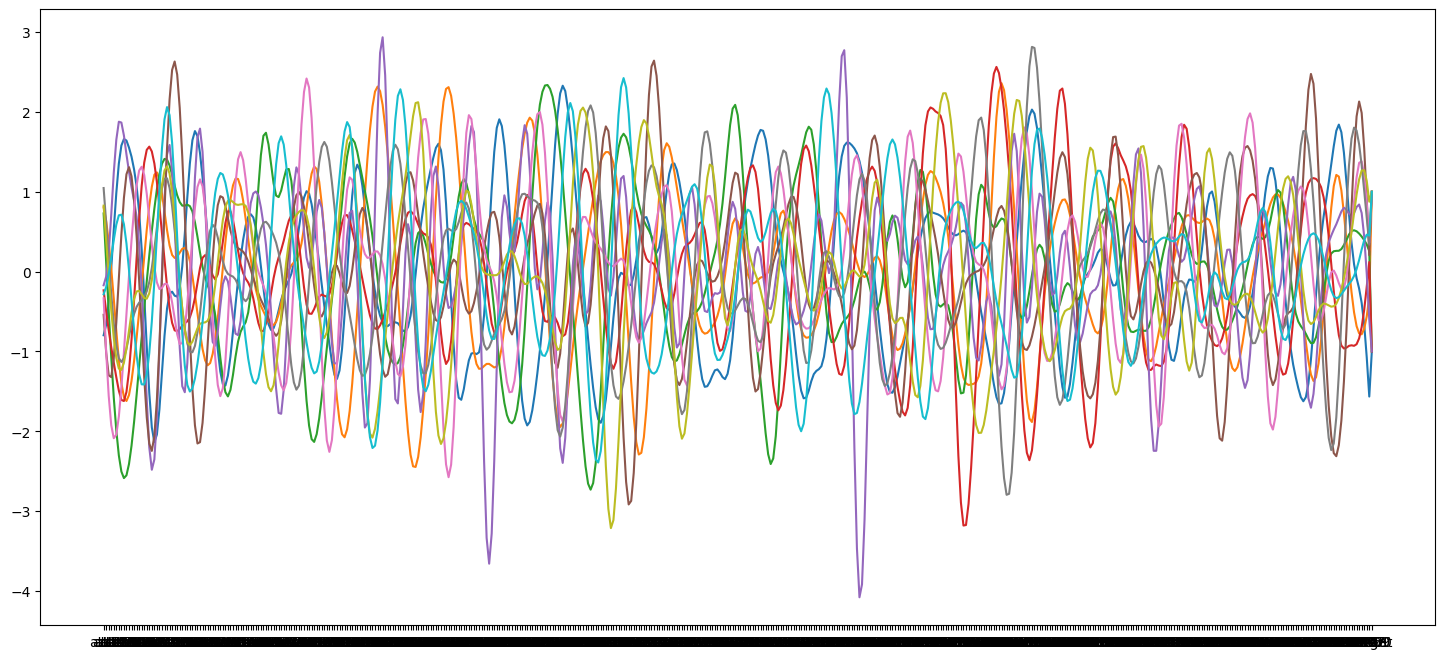

In [18]:
plt.figure(figsize=(18, 8))
for idx in range(10):
    plt.plot(df_train.iloc[idx, :])
plt.show()